In [1]:
import pickle
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# ML stuff
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
# interpolation if needed
kspace = np.arange(2,12.05,.05)
def interpol(exafs):
    x, y = exafs.transpose()
    f1=interp1d(x, y, kind='cubic')
    test_real=f1(kspace)
    return test_real

# Import data 

In [3]:
# set up the data dictionary
data_dict = {}
data_dict["rdf"] = []
data_dict["chi"] = []

In [4]:
# read the data from disk and put it in the dictionary
with open('../data/rdf_Au_cubo_0.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["rdf"].append(data)

with open('../data/chi_Au_cubo_0.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["chi"].append(data)

with open('../data/rdf_Au_cubo_1.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["rdf"].append(data)

with open('../data/chi_Au_cubo_1.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["chi"].append(data)

with open('../data/rdf_Au_cubo_6000.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["rdf"].append(data)

with open('../data/chi_Au_cubo_6000.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["chi"].append(data)

with open('../data/rdf_Au_deca_0.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["rdf"].append(data)

with open('../data/chi_Au_deca_0.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["chi"].append(data)

with open('../data/rdf_Au_deca_6000.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["rdf"].append(data)

with open('../data/chi_Au_deca_6000.pickle', 'rb') as f:
    data = pickle.load(f)
    data_dict["chi"].append(data)


In [5]:
# add elements from data_dict to chi_array and rdf_array -- this is method is dumb, I should have imported the data in a better way
chi_array = []
rdf_array = []
for i in range(len(data_dict["chi"])):
    for j in range(len(data_dict["chi"][i])):
        chi_array.append(interpol(data_dict["chi"][i][j])) # interpolating the data to a constrained k-space
        rdf_array.append(data_dict["rdf"][i][j])

chi_array = np.array(chi_array)
rdf_array = np.array(rdf_array)

# Training

In [6]:
rdf_examples = rdf_array
exafs_examples = chi_array 

# Split the data
x_train, x_test, y_train, y_test = train_test_split(rdf_examples, exafs_examples, test_size=0.20)

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Define the model (this one works well but probably could be improved)
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=10, stride=2, padding=4)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=10, stride=1, padding=4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 39, 600)
        self.fc2 = nn.Linear(600, 600)
        self.fc3 = nn.Linear(600, 201)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(-1, 240)             # Ensure input is of shape (batch_size, 240)
        x = x.view(-1, 3, 80)           # Reshape to (batch_size, 3, 80)
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        return x

# Instantiate the model and move it to the device
model_nano_Au = Model2().to(device)
print(model_nano_Au)  # Print the model summary

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nano_Au.parameters(), lr=0.0001)

# Early stopping parameters
num_epochs = 100
patience = 10
min_delta = 0.0000003
best_val_loss = float('inf')
counter = 0
best_model_state = None

# Training loop with early stopping
for epoch in range(num_epochs):
    # Training
    model_nano_Au.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        # Move data to the device
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model_nano_Au(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model_nano_Au.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move data to the device
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model_nano_Au(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')

    # Early stopping check
    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model_nano_Au.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping triggered')
            model_nano_Au.load_state_dict(best_model_state)
            break


Using device: cuda
Model2(
  (conv1): Conv1d(3, 32, kernel_size=(10,), stride=(2,), padding=(4,))
  (conv2): Conv1d(32, 32, kernel_size=(10,), stride=(1,), padding=(4,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1248, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=201, bias=True)
  (tanh): Tanh()
)
Epoch [1/100], Train Loss: 0.00025870, Val Loss: 0.00003828
Epoch [2/100], Train Loss: 0.00002872, Val Loss: 0.00002309
Epoch [3/100], Train Loss: 0.00002137, Val Loss: 0.00002316
Epoch [4/100], Train Loss: 0.00001821, Val Loss: 0.00001545
Epoch [5/100], Train Loss: 0.00001615, Val Loss: 0.00001566
Epoch [6/100], Train Loss: 0.00001456, Val Loss: 0.00001318
Epoch [7/100], Train Loss: 0.00001362, Val Loss: 0.00001157
Epoch [8/100], Train Loss: 0.00001255, Val Loss: 0.00001179
Epoch [9/100], Train Loss: 0.00001213, Val Loss: 0.00001105
Epoch [10/100], Train Loss: 0.00001128

In [7]:
# save the model
torch.save(model_nano_Au.state_dict(), 'nano_Au_model.pth')

# Validation

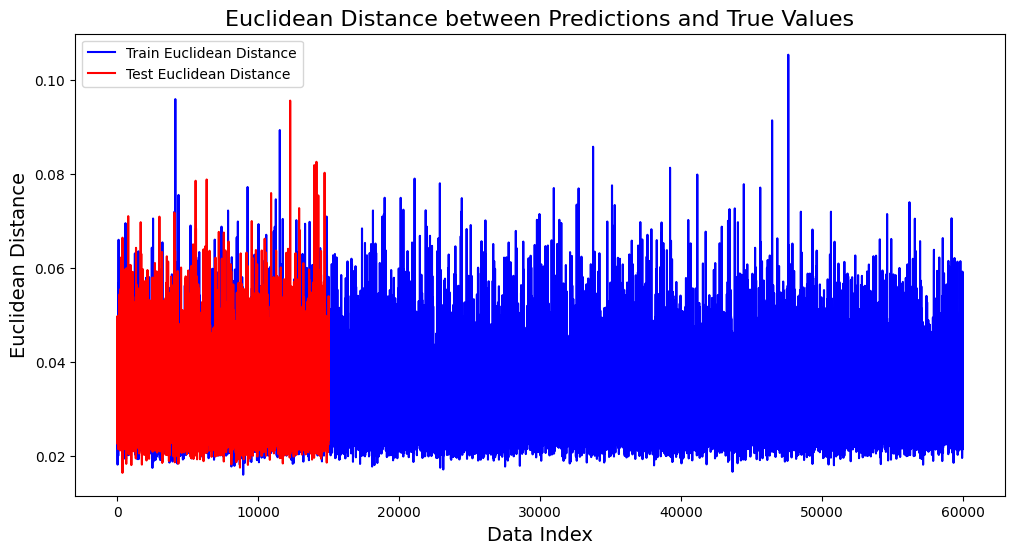

In [11]:
# Set the model to evaluation mode
model_nano_Au.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Move test and train inputs to the same device as the model
    test_inputs = x_test_tensor.to(device)
    train_inputs = x_train_tensor.to(device)
    
    # Generate predictions for test data
    test_predictions = model_nano_Au(test_inputs)
    test_predictions = test_predictions.cpu().numpy()
    
    # Generate predictions for train data
    train_predictions = model_nano_Au(train_inputs)
    train_predictions = train_predictions.cpu().numpy()

# Convert true targets to numpy arrays
y_test = y_test_tensor.numpy()
y_train = y_train_tensor.numpy()

# Compute Euclidean distances between predictions and true values for each sample
euclidean_distances_test = np.linalg.norm(test_predictions - y_test, axis=1)
euclidean_distances_train = np.linalg.norm(train_predictions - y_train, axis=1)

# Alternatively, compute Mean Squared Error (MSE) for each sample
mse_metric_test = np.mean((test_predictions - y_test) ** 2, axis=1)
mse_metric_train = np.mean((train_predictions - y_train) ** 2, axis=1)

# Plot the Euclidean distances for both train and test data
plt.figure(figsize=(12, 6))
plt.plot(euclidean_distances_train, color='blue', label='Train Euclidean Distance')
plt.plot(euclidean_distances_test, color='red', label='Test Euclidean Distance')
plt.ylabel('Euclidean Distance', fontsize=14)
plt.xlabel('Data Index', fontsize=14)
plt.title('Euclidean Distance between Predictions and True Values', fontsize=16)
plt.legend()
plt.show()

# # Plot the MSE metric for both train and test data
# plt.figure(figsize=(12, 6))
# plt.plot(mse_metric_train, color='blue', label='Train MSE')
# plt.plot(mse_metric_test, color='red', label='Test MSE')
# plt.ylabel('Mean Squared Error', fontsize=14)
# plt.xlabel('Data Index', fontsize=14)
# plt.title('Mean Squared Error between Predictions and True Values', fontsize=16)
# plt.legend()
# plt.show()


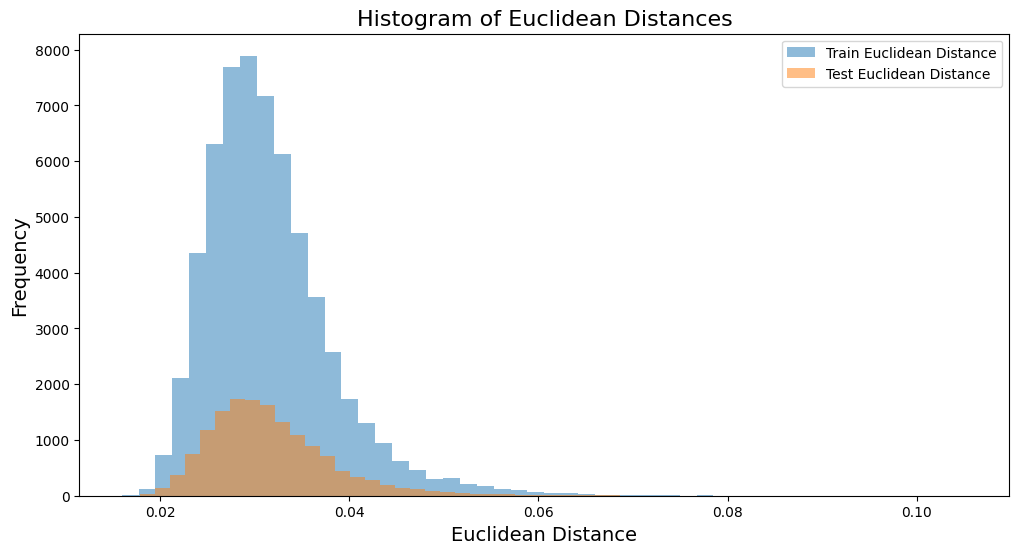

In [12]:
plt.figure(figsize=(12, 6))
plt.hist(euclidean_distances_train, bins=50, alpha=0.5, label='Train Euclidean Distance')
plt.hist(euclidean_distances_test, bins=50, alpha=0.5, label='Test Euclidean Distance')
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Euclidean Distance', fontsize=14)
plt.title('Histogram of Euclidean Distances', fontsize=16)
plt.legend()
plt.show()


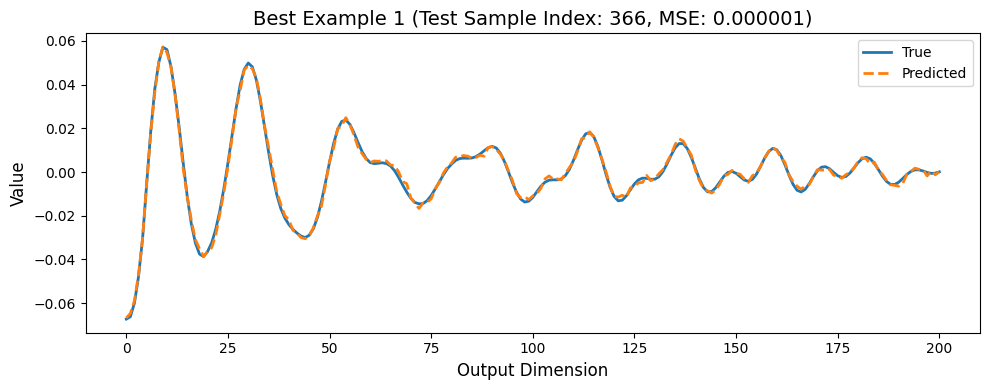

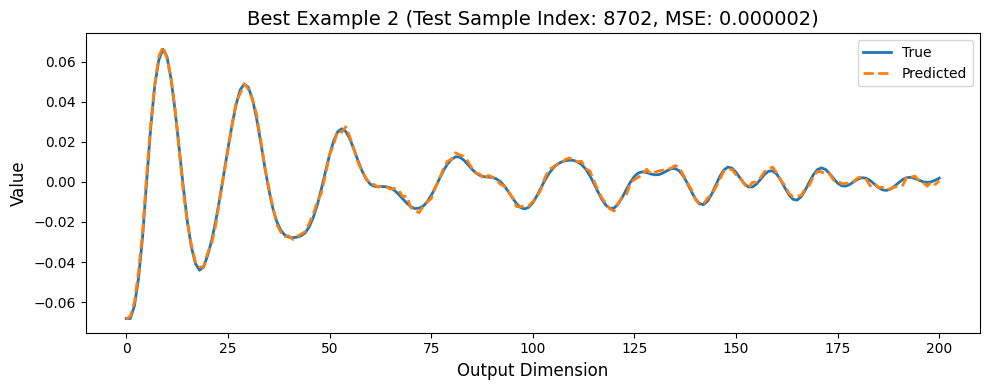

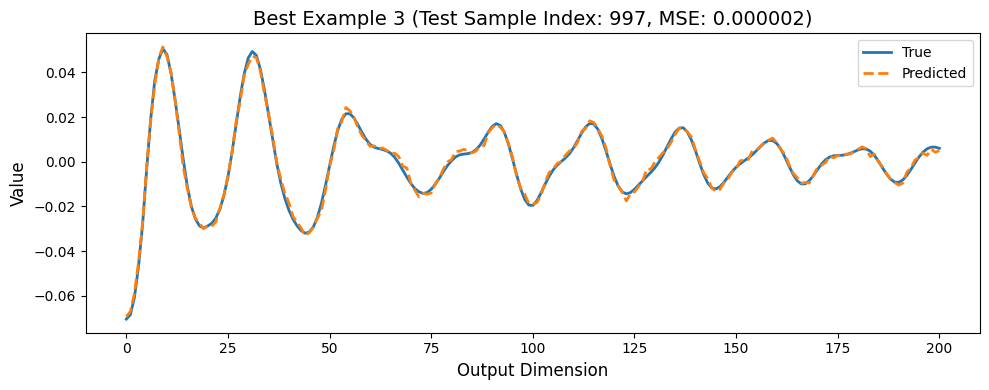

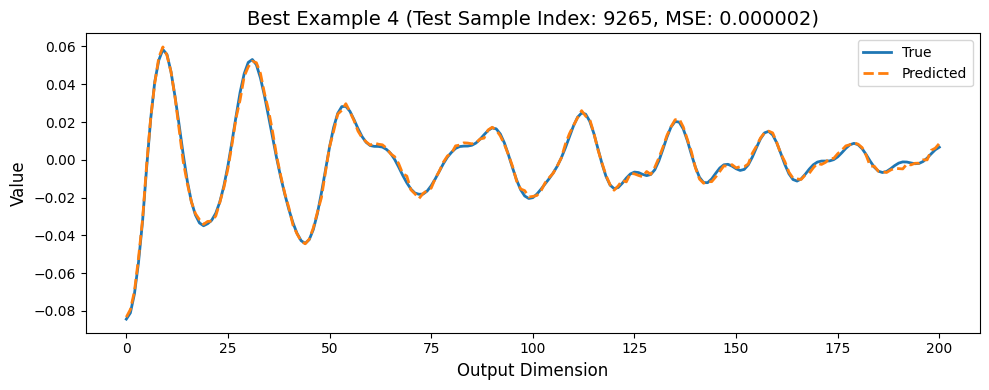

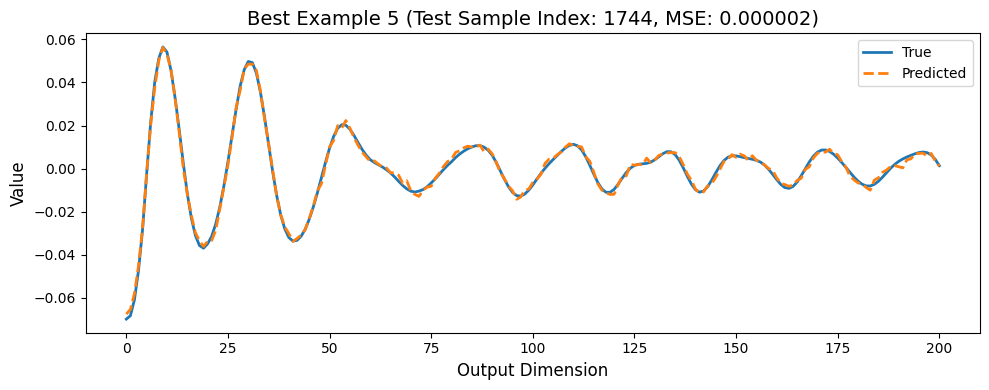

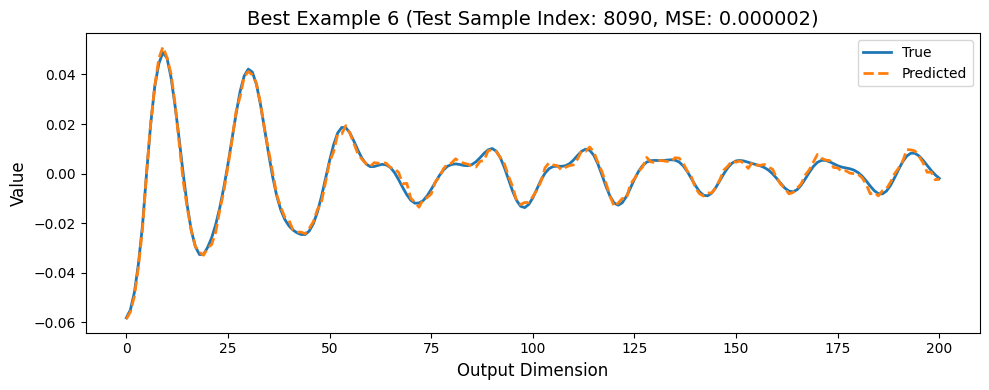

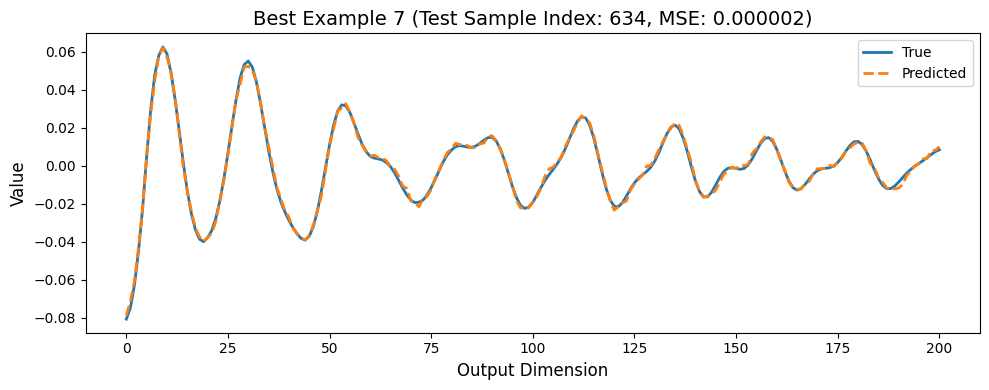

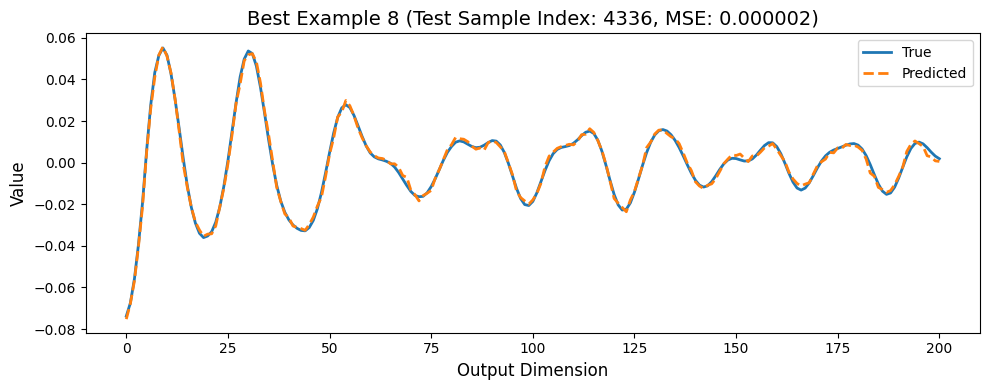

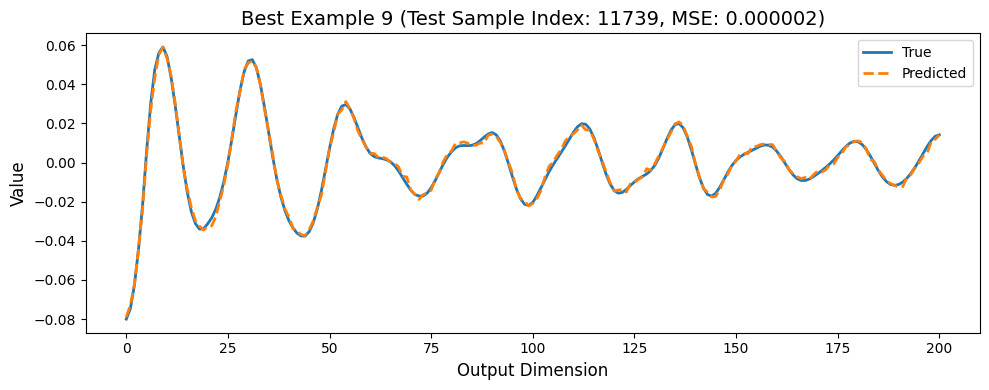

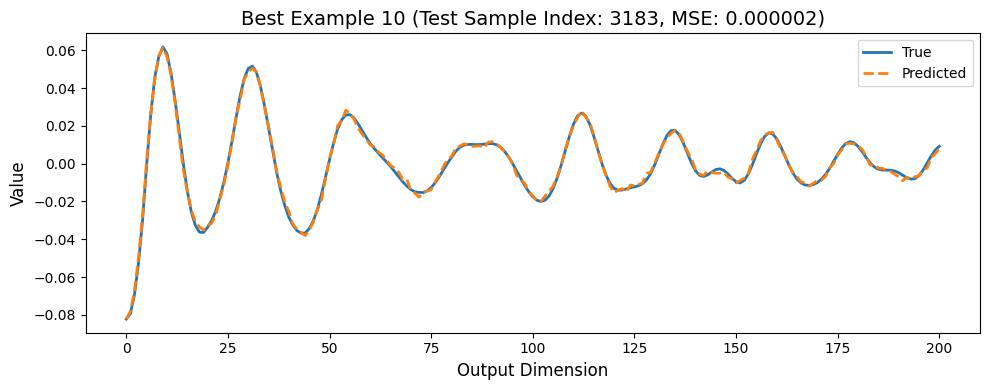

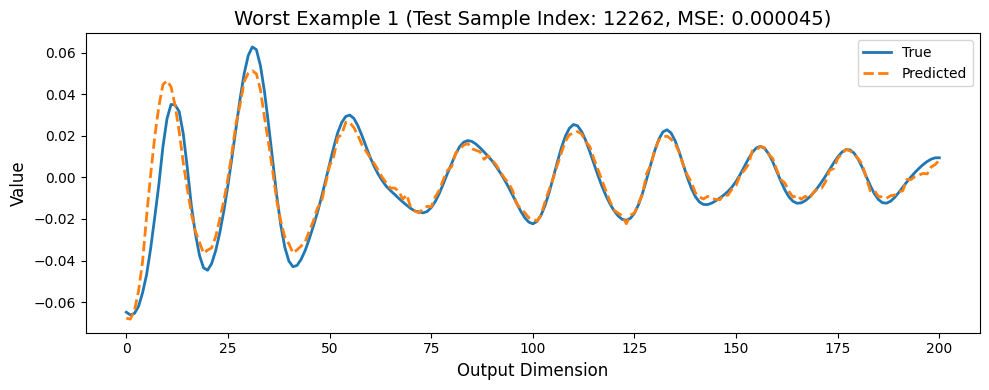

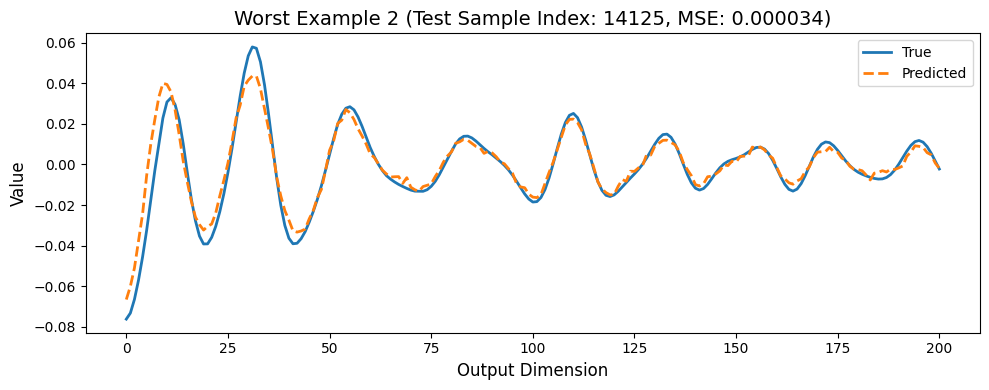

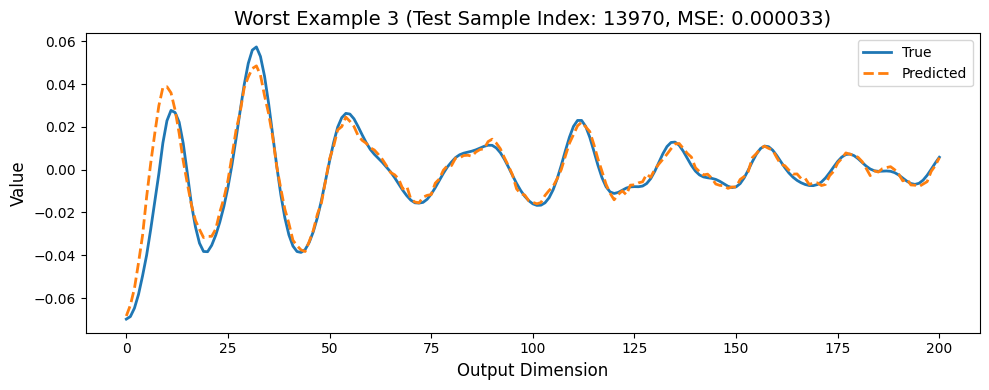

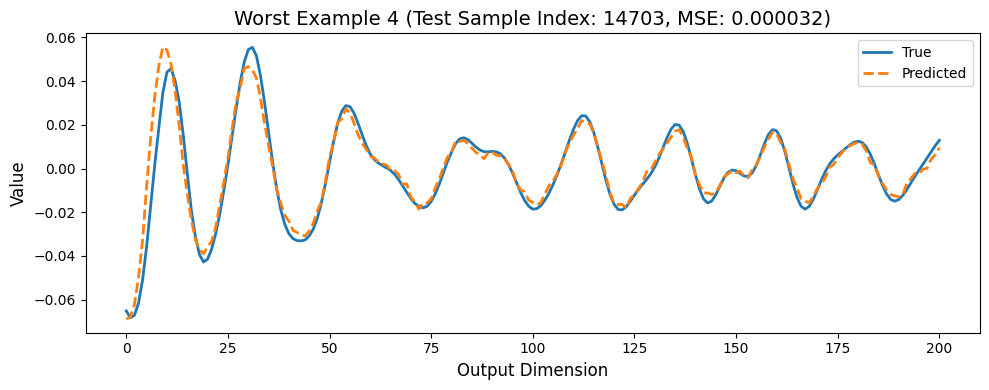

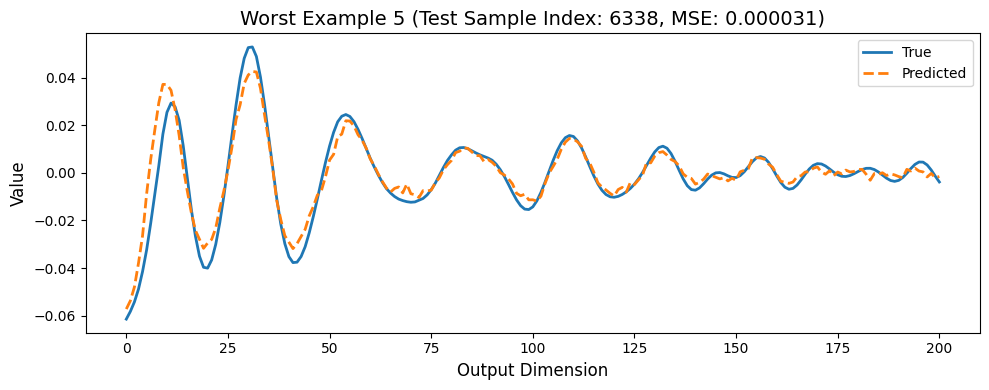

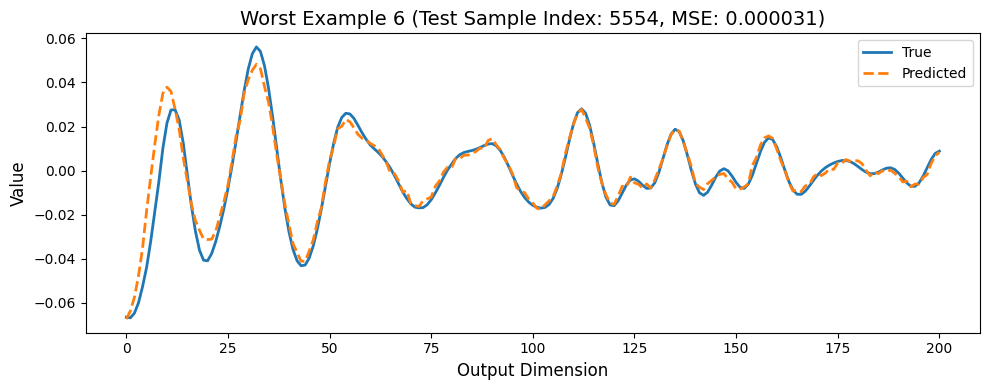

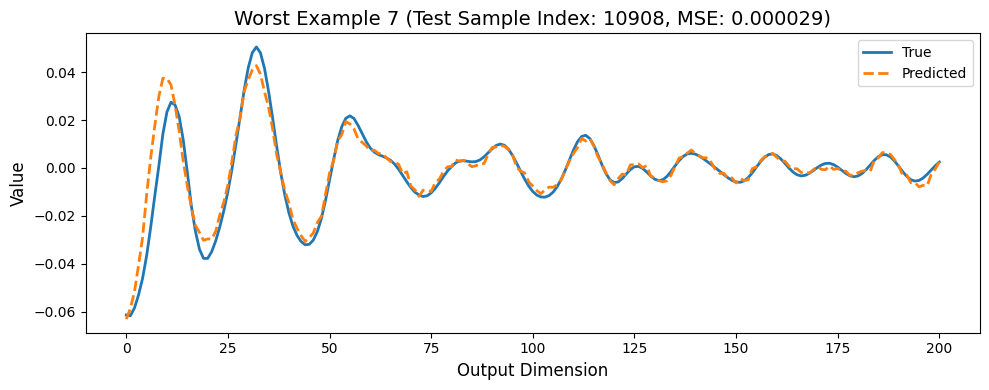

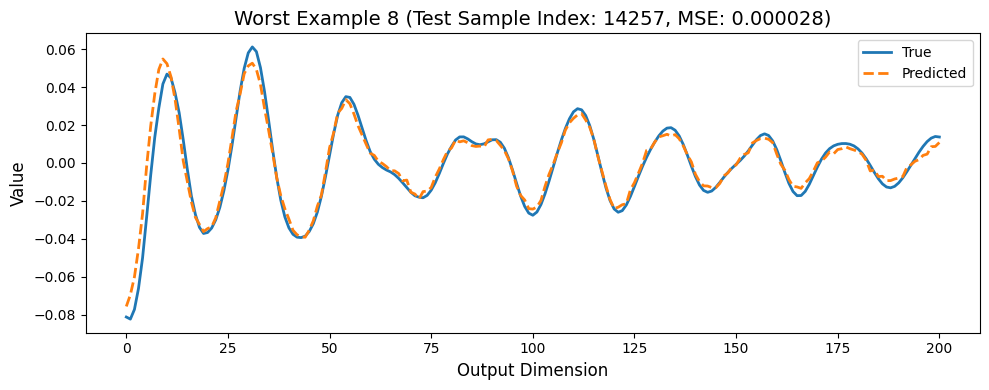

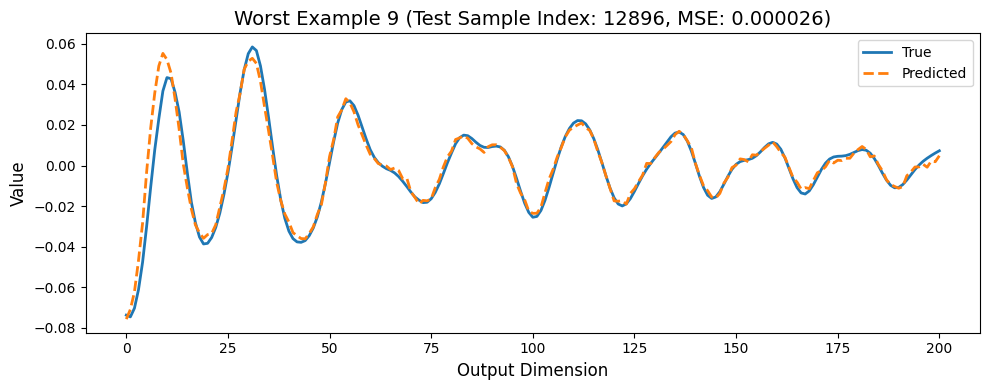

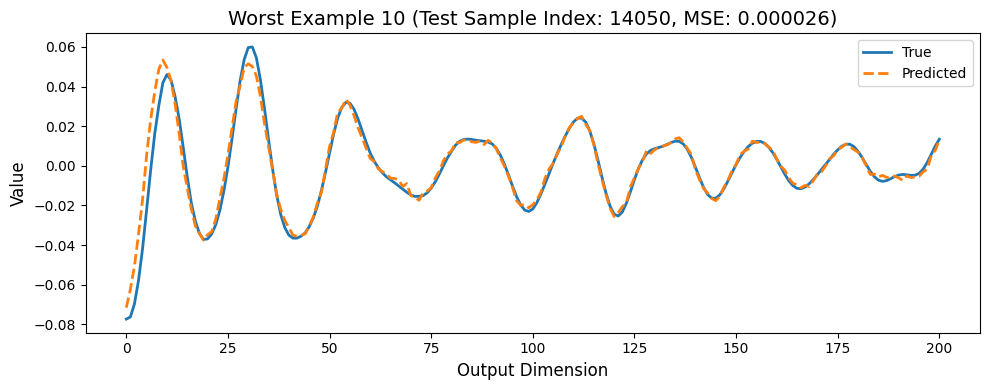

In [10]:
# Ensure necessary libraries are imported
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model_nano_Au.eval()

# Disable gradient computation for inference
with torch.no_grad():
    # Move test inputs to the same device as the model
    test_inputs = x_test_tensor.to(device)
    
    # Generate predictions for test data
    test_predictions = model_nano_Au(test_inputs)
    test_predictions = test_predictions.cpu().numpy()

# Convert true targets to numpy arrays
y_test = y_test_tensor.numpy()

# Compute Mean Squared Error (MSE) for each sample
mse_metric_test = np.mean((test_predictions - y_test) ** 2, axis=1)

# Identify the indices of the 10 best (lowest MSE) and 10 worst (highest MSE) examples
best_indices = np.argsort(mse_metric_test)[:10]         # Indices of the 10 smallest errors
worst_indices = np.argsort(mse_metric_test)[-10:][::-1] # Indices of the 10 largest errors, reversed for descending order

# Plot the 10 best examples
for i, idx in enumerate(best_indices):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test[idx], label='True', linewidth=2)
    plt.plot(test_predictions[idx], label='Predicted', linestyle='--', linewidth=2)
    plt.title(f'Best Example {i+1} (Test Sample Index: {idx}, MSE: {mse_metric_test[idx]:.6f})', fontsize=14)
    plt.xlabel('Output Dimension', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the 10 worst examples
for i, idx in enumerate(worst_indices):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test[idx], label='True', linewidth=2)
    plt.plot(test_predictions[idx], label='Predicted', linestyle='--', linewidth=2)
    plt.title(f'Worst Example {i+1} (Test Sample Index: {idx}, MSE: {mse_metric_test[idx]:.6f})', fontsize=14)
    plt.xlabel('Output Dimension', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
